In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten, Conv2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
DATASET_DIR = "/kaggle/input/plantdisease/PlantVillage"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

In [5]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2,
    rotation_range = 20,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True
)

val_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = False
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [6]:
base_model = ResNet50(weights='imagenet', include_top = False, input_shape = (224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [8]:
base_model.trainable = False

In [9]:
x = base_model.output
x = MaxPooling2D(pool_size=(2, 2))(x)

x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

x = Dense(128, activation = "relu")(x)

x = Dropout(0.3)(x)

output = Dense(train_generator.num_classes, activation = "softmax")(x)

In [10]:
model = Model(inputs = base_model.input, outputs = output)

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,851,919 (90.99 MB)

 Trainable params: 264,207 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [14]:
history = model.fit(
    train_generator, 
    validation_data = val_generator,
    epochs = EPOCHS,
    callbacks = early_stop
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


517/517 ━━━━━━━━━━━━━━━━━━━━ 339s 623ms/step - accuracy: 0.1226 - loss: 2.7673 - val_accuracy: 0.1744 - val_loss: 2.4621
Epoch 2/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 228s 436ms/step - accuracy: 0.1734 - loss: 2.4817 - val_accuracy: 0.2011 - val_loss: 2.3732
Epoch 3/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 223s 426ms/step - accuracy: 0.1885 - loss: 2.4113 - val_accuracy: 0.2067 - val_loss: 2.3242
Epoch 4/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 227s 435ms/step - accuracy: 0.1960 - loss: 2.3840 - val_accuracy: 0.2154 - val_loss: 2.2855
Epoch 5/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 229s 439ms/step - accuracy: 0.2125 - loss: 2.3409 - val_accuracy: 0.2392 - val_loss: 2.2508
Epoch 6/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 229s 438ms/step - accuracy: 0.2135 - loss: 2.3345 - val_accuracy: 0.2441 - val_loss: 2.2282
Epoch 7/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 229s 439ms/step - accuracy: 0.2210 - loss: 2.3100 - val_accuracy: 0.2382 - val_loss: 2.2155
Epoch 8/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 228s 436ms/step - accuracy: 0.2189 - loss: 2.29

In [15]:
model_filename = "village_dataset_model.h5"
model.save(model_filename)
print(f"\nModel saved to {model_filename}")


Model saved to village_dataset_model.h5


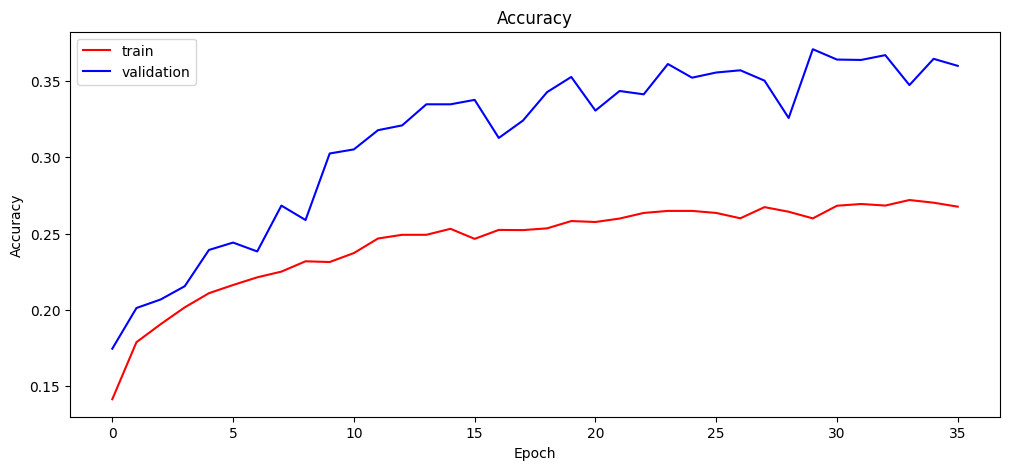

In [16]:
plt.figure(figsize = (12, 5))

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

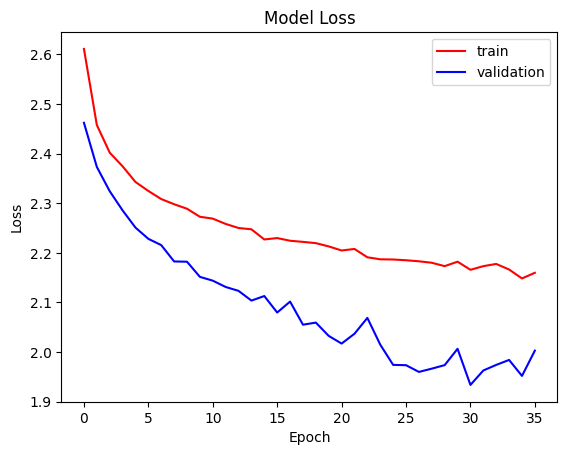

In [17]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

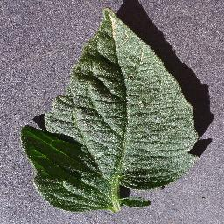

In [18]:
from tensorflow.keras.preprocessing import image

img_path = '/kaggle/input/plantdisease/PlantVillage/Tomato_healthy/0031da2a-8edd-468f-a8b1-106657717a32___RS_HL 0105.JPG'

img = image.load_img(img_path, target_size = IMAGE_SIZE)

img

In [19]:
class_labels = list(val_generator.class_indices.keys())
img_array = image.img_to_array(img)
img_array = img_array/255.0
img_array = np.expand_dims(img_array, axis = 0)

prediction = model.predict(img_array)
prediction_class_index = np.argmax(prediction)
prediction_class_label = class_labels[prediction_class_index]
prediction_class_label

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


'Tomato_healthy'

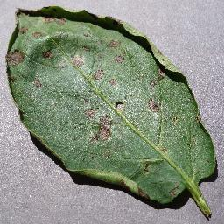

In [20]:
from tensorflow.keras.preprocessing import image

img_path = '/kaggle/input/plantdisease/PlantVillage/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG'

img = image.load_img(img_path, target_size = IMAGE_SIZE)

img

In [21]:
class_labels = list(val_generator.class_indices.keys())
img_array = image.img_to_array(img)
img_array = img_array/255.0
img_array = np.expand_dims(img_array, axis = 0)

prediction = model.predict(img_array)
prediction_class_index = np.argmax(prediction)
prediction_class_label = class_labels[prediction_class_index]
prediction_class_label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'Potato___Early_blight'

Found 5878 images belonging to 6 classes.
Found 1467 images belonging to 6 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 143s 679ms/step - accuracy: 0.5965 - loss: 1.2219 - val_accuracy: 0.9059 - val_loss: 0.2886 - learning_rate: 0.0010
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 96s 506ms/step - accuracy: 0.8355 - loss: 0.4372 - val_accuracy: 0.9189 - val_loss: 0.2261 - learning_rate: 0.0010
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 96s 504ms/step - accuracy: 0.8766 - loss: 0.3490 - val_accuracy: 0.9373 - val_loss: 0.1640 - learning_rate: 0.0010
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 97s 511ms/step - accuracy: 0.8871 - loss: 0.3310 - val_accuracy: 0.9393 - val_loss: 0.1652 - learning_rate: 0.0010
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 96s 505ms/step - accuracy: 0.8983 - loss: 0.2877 - val_accuracy: 0.9434 - val_loss: 0.1446 - learning_rate: 0.0010
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 96s 504ms/step - accuracy: 0.9038 - loss: 0.2752 

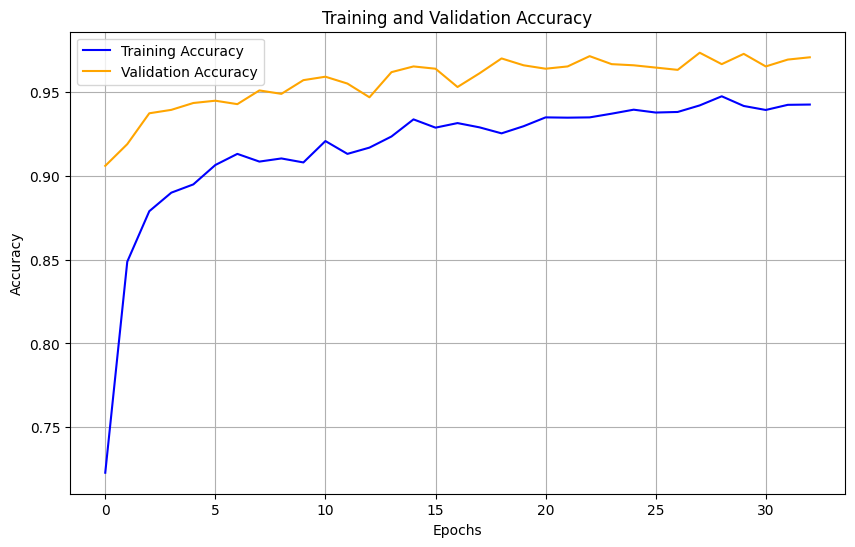

46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 409ms/step - accuracy: 0.9423 - loss: 0.1222
Validation Loss: 0.08115952461957932, Validation Accuracy: 0.96523517370224


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define constants
DATASET_DIR = '/kaggle/input/plant-disease-dataset/plant dataset'  # Path to your dataset
IMAGE_SIZE = (224, 224)  # Image size
BATCH_SIZE = 32  # Batch size
EPOCHS = 50  # Number of epochs

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0
)

# Data generators
train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Load pre-trained InceptionV3 model without the top layer (exclude the classification head)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = MaxPooling2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, lr_scheduler]
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')


In [3]:
model.save('village_classifier.h5')